In [1]:
import os
import pandas as pd

In [2]:
from mrcnn.utils import Dataset
from os import listdir
from xml.etree import ElementTree
import os
from mrcnn.config import Config

In [3]:
from mrcnn.model import MaskRCNN
# import sys
import pandas as pd
from numpy import zeros
from numpy import asarray
import numpy as np
from matplotlib import pyplot
import keras as ks
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


In [4]:
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

from numpy import expand_dims

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

### Images categorized in different weather conditions

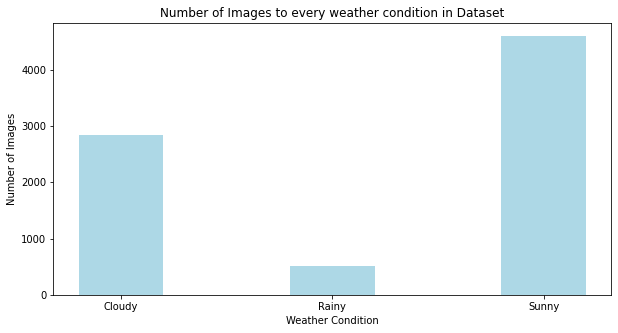

In [5]:

dataset_directory = 'C:/Users/vbhad/Downloads/PKLot/PKLot/PKLot'
three_diff_cameras = os.listdir(dataset_directory)
all_counts = {}
for i in three_diff_cameras:
    weather_dir = os.listdir(dataset_directory+'/'+i)
    for j in weather_dir:
        l = 0
        dates = os.listdir(dataset_directory+'/'+i+'/'+j)
        for k in dates:
            all_files = os.listdir(dataset_directory+'/'+i+'/'+j+'/'+k)
            used_for_flag = True
            for image_file in all_files:
                if image_file.endswith(".jpg"):
                    l +=1
        if j in all_counts:
            all_counts[j] = all_counts[j] + l
        else:
            all_counts[j] = 0
        l = 0

fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(all_counts.keys(),all_counts.values(), color ='lightblue', width = 0.4)
 
plt.xlabel("Weather Condition")
plt.ylabel("Number of Images")
plt.title("Number of Images to every weather condition in Dataset")
plt.show()       

### Data Preprocessing

In [6]:
# Collecting needed information: image_id, image_name, image_path & xml file path 
def data_preprocessing(dataset_directory, limit= sum(all_counts.values())):
    counter = 0
    df = pd.DataFrame()
    image_ids = []
    image_names = []
    path = []
    used_for = []
    three_diff_cameras = os.listdir(dataset_directory)
    
    for i in three_diff_cameras:
        weather_dir = os.listdir(dataset_directory+'/'+i)
        for j in weather_dir:
            dates = os.listdir(dataset_directory+'/'+i+'/'+j)
            for k in dates:
                all_files = os.listdir(dataset_directory+'/'+i+'/'+j+'/'+k)
                used_for_flag = True
                for image_file in all_files:
                    if image_file.endswith(".jpg"):
                        counter +=1
                        image_names.append(image_file)
                        used_for.append(used_for_flag)
                        path.append(dataset_directory+'/'+i+'/'+j+'/'+k)
                        if used_for_flag:
                            used_for_flag = False
                        else:
                            used_for_flag = True
                        if counter == limit:
                            df['name'] = image_names
                            df['path'] = path
                            df['used_for'] = used_for
                            return df                   
    return

dataset_directory = 'C:/Users/vbhad/Downloads/PKLot/PKLot/PKLot'
df = data_preprocessing(dataset_directory,2000)

In [7]:
print("Total Images to Process: ",len(df))
df.head()

Total Images to Process:  2000


,name,path,used_for
0,2012-09-12_06_05_16.jpg,C:/Users/vbhad/Downloads/PKLot/PKLot/PKLot/PUC...,True
1,2012-09-12_06_10_30.jpg,C:/Users/vbhad/Downloads/PKLot/PKLot/PKLot/PUC...,False
2,2012-09-12_06_15_44.jpg,C:/Users/vbhad/Downloads/PKLot/PKLot/PKLot/PUC...,True
3,2012-09-12_06_20_57.jpg,C:/Users/vbhad/Downloads/PKLot/PKLot/PKLot/PUC...,False
4,2012-09-12_06_26_11.jpg,C:/Users/vbhad/Downloads/PKLot/PKLot/PKLot/PUC...,True


## ParkingSpotDetection Class implements required methods

In [8]:
class ParkingSpotDetection(Dataset):
    key_error_count = 0
        
    # This function takes care of loading the data from XML
    def load_dataset(self, dataset_directory, is_train=True):
        self.add_class('parking', 1, 'Occupied') 
        self.add_class('parking', 2, 'NotOccupied') 
        if is_train:
            for key, value in df.iterrows():
                if value['used_for'] == is_train:
                    image_id = value['name'][:-4]
                    img_path= value['path'] + '/' + value['name']
                    label_path = value['path'] + '/' + image_id + '.xml'
                    self.add_image('parking', image_id=image_id, path=img_path, annotation=label_path)

        elif not is_train:
            for key, value in df.iterrows():
                if value['used_for'] == is_train:
                    image_id = value['name'][:-4]
                    img_path= value['path'] + '/' + value['name']
                    label_path = value['path'] + '/' + image_id + '.xml'
                    self.add_image('parking', image_id=image_id, path=img_path, annotation=label_path)
                    
    # Get all shapes to mask for a perticular image 
    def extract_box_shape(self, filename): 
        tree = ElementTree.parse(filename)
        root = tree.getroot()
        box_shape = []
        for space in root.getiterator('space'):
            try:
                cls_id= int(space.attrib['occupied'])
                for rect in space.findall('rotatedRect/center'):
                    x= int(rect.get('x'))
                    y= int(rect.get('y'))
                for rect in space.findall('rotatedRect/size'): 
                    w= int(rect.get('w'))
                    h = int(rect.get('h'))
                for rect in space.findall('rotatedRect/angle'): 
                    d = int(rect.get('d'))
                coors = [cls_id, x, y, w, h, d]
                box_shape.append(coors)
            except KeyError:
                ParkingSpotDetection.key_error_count +=1
                continue

        return box_shape
    
    # Implements the extracted shape & generates mask np array
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        box_shape = self.extract_box_shape(path)
        mask = np.zeros([720, 1280, len(box_shape)], dtype='uint8')
        class_ids = []
        for i in range(len(box_shape)):
            box = box_shape[i]
            cls_id, x, y, w, h, d= box 
            row_s, row_e = y-(w), y+(w//2) 
            col_s, col_e = x-(h//2), x+(h//2) 
            mask[row_s:row_e, col_s: col_e, i] = 1
            if cls_id==1:
                class_ids.append(self.class_names.index('Occupied'))
            elif cls_id==0:
                class_ids.append(self.class_names.index('NotOccupied'))
        return mask, np.asarray(class_ids, dtype='int32')

### Preparing data for Training & Test

In [9]:
train_set = ParkingSpotDetection()
train_set.load_dataset(True)
train_set.prepare()
print('Images for Training: %d' % len(train_set.image_ids))

test_set = ParkingSpotDetection()
test_set.load_dataset(False)
test_set.prepare()
print('Images for Testing: %d' % len(test_set.image_ids))


Images for Training: 1005
Images for Testing: 1005


### Mask on image using data from xml 

In [12]:
# load an image
image_id = 0
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(720, 1280, 3)
(720, 1280, 100)


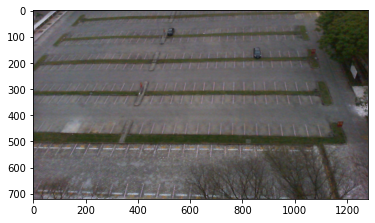

In [13]:
pyplot.imshow(image)

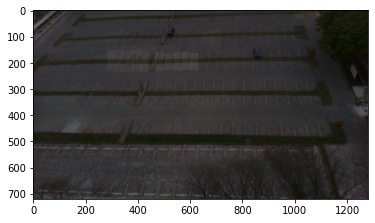

(720, 1280, 3)
(720, 1280, 100) <class 'numpy.ndarray'>


In [14]:
# the mask
pyplot.imshow(image)
for i in range(10):
    pyplot.imshow(mask[:, :, i], cmap='gray', alpha=0.06)
pyplot.show()

print(image.shape)
print(mask.shape,type(image))

In [47]:
class ParkingConfig(Config):
    NAME = 'parking_cfg'
    NUM_CLASSES = 1+2
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = ParkingConfig()
# config.display()

### Creating MaskRCNN object

In [33]:
model = MaskRCNN(mode='training', model_dir='C:/Users/vbhad/Courses/Pattern/stack', config=config)


### Loading pretrained coco model

In [34]:
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=['mrcnn_class_logits','mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])


### Training the model

In [35]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\vbhad\Courses\Pattern\new\logdir\train\mask_rcnn_parking_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcn

C:\Users\vbhad\anaconda3\envs\new\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\vbhad\anaconda3\envs\new\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\vbhad\anaconda3\envs\new\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
1000/1000 [==============================] - 24172s 24s/step - loss: 1.1726 - val_loss: 0.4494
Epoch 2/5
1000/1000 [==============================] - 24167s 24s/step - loss: 0.6805 - val_loss: 0.5607
Epoch 3/5
1000/1000 [==============================] - 35588s 36s/step - loss: 0.5148 - val_loss: 0.4564
Epoch 4/5
1000/1000 [==============================] - 22952s 23s/step - loss: 0.4253 - val_loss: 0.6539
Epoch 5/5
1000/1000 [==============================] - 22522s 23s/step - loss: 0.3618 - val_loss: 0.3024


### Predicting a random image

In [52]:
#  define the prediction configuration
class SecondConfigurationToPredict(Config):
    NAME = "parking_cfg"
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
configuration_to_predict = SecondConfigurationToPredict()

In [53]:
# load trained model
model_output = MaskRCNN(mode='inference', model_dir='./', config=configuration_to_predict)
model_output.load_weights('mask_rcnn_parking_cfg_0005.h5', by_name=True, exclude=['mrcnn_class_logits','mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

### Importing required libraries to plot results

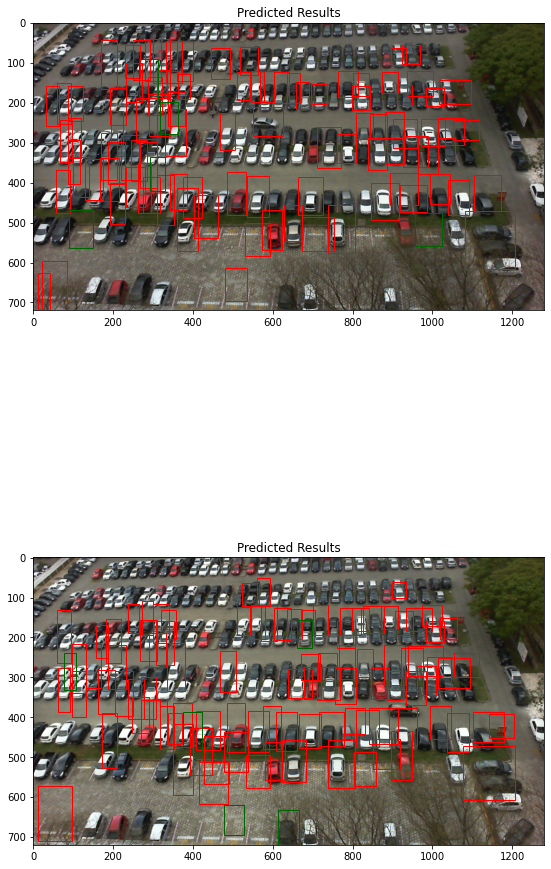

In [59]:
# plot a number of photos with ground truth and predictions
def predict_result(test_set, model, config, n_images=1,start_from=10):
    plt.figure(figsize=(15,15))
    for i in range(n_images):
        image_to_target = i + start_from + 5
        image = test_set.load_image(image_to_target)
        mask, classes = test_set.load_mask(image_to_target)
        
        scaled_image = mold_image(image, config)
        sample = expand_dims(scaled_image, 0)
        yhat = model.detect(sample, verbose=0)[0]
        
        plt.subplot(2, 2, i*2+1)
        plt.imshow(image)

        plt.title('Predicted Results')
        ax = plt.gca()
        for box, single_class in zip(yhat['rois'], classes):
            y1, x1, y2, x2 = box
            width, height = x2 - x1, y2 - y1
            if single_class == 1:
                generated_box = Rectangle((x1, y1), width, height, fill=False, color='red')
            elif single_class == 2:
                generated_box = Rectangle((x1, y1), width, height, fill=False, color='darkgreen')
            ax.add_patch(generated_box)

    plt.tight_layout()
    plt.show()
    
# plot predictions for test dataset
predict_result(test_set, model_output, configuration_to_predict,2,10)